# CE 88 - Data Science for Smart Cities
## Midterm - Due: Nov. 11, 2018
### By: Haakon Ludvig Langeland Ervik

This notebook explores a dataset of taxi trips from San Francisco. Its aim is to do an Exploratory Data Analysis to make inferences about the data and then implement a model which may the used to predict taxi fares.

The accuracy of the model is assessed using root mean square error by splitting the given data into a training-set and a test-set.

The model is also assessed against a test set on Kaggle.

## Exploratory Data Analysis 

The aim with this section is the explore interesting features of the data.

Many interesting aspects may be explored, and some will prove more or less useful when implementing a model to predict taxi fares.

In [1]:
# First, some imports:

from datascience import *
import datetime
import matplotlib.pyplot as plt
import numpy as np
from datascience import minimize
plt.style.use('fivethirtyeight')

#plotting
import seaborn as sns

import pandas as pd

%matplotlib inline

### Training data 

In [2]:
sf_taxi_trips = Table.read_table('Taxi_Train.csv')

### Time formats 

In [3]:
def get_hour(s): 
    return datetime.datetime.strptime(s, "%m/%d/%y %H:%M").hour

def get_date(s): 
    return datetime.datetime.strptime(s, "%m/%d/%y %H:%M").date()

def get_weekday(s): # 0 = Monday - 6= Sunday
    return datetime.datetime.strptime(s, "%m/%d/%y %H:%M").date().weekday()

def get_duration(start, end): 
    start_time = datetime.datetime.strptime(start, "%m/%d/%y %H:%M")
    end_time = datetime.datetime.strptime(end, "%m/%d/%y %H:%M")
    return (end_time-start_time).seconds/60.

In [4]:
sf_taxi_trips['duration'] = sf_taxi_trips.apply(get_duration, 'start_time', 'end_time')
sf_taxi_trips['start hour'] = sf_taxi_trips.apply(get_hour, 'start_time')
sf_taxi_trips['date'] = sf_taxi_trips.apply(get_date, 'start_time')
sf_taxi_trips['day of week'] = sf_taxi_trips.apply(get_weekday, 'start_time')

Text(0.5, 1.0, 'Distribution of Trip Fare')

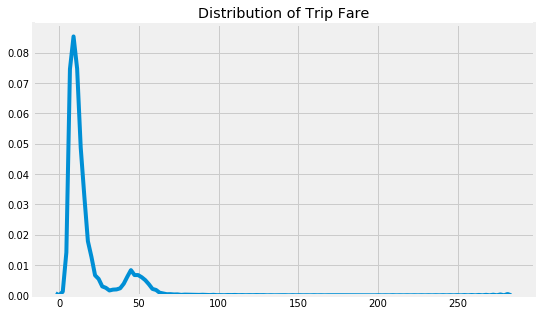

In [5]:
plt.figure(figsize=(8,5))
sns.kdeplot(sf_taxi_trips['fare']).set_title("Distribution of Trip Fare")

 The above plot show the distribution of trip fares. We not that most trips have a fare of about \\$ 17. There is also a bunch of trips at \\$ 50.

#### Removal of 0-fares
Removing 0-fares - reasonably we should assume that taxi-trips have a non-zero cost.

In [6]:
sf_taxi_trips = sf_taxi_trips.where(sf_taxi_trips['fare']>0)

Text(0.5, 1.0, 'Distribution of fare amount (log scale)')

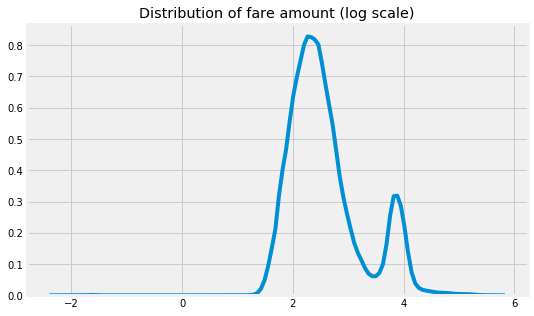

In [7]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(sf_taxi_trips['fare'])).set_title("Distribution of fare amount (log scale)")

On the log-plot we see more clearly the variation of fare amounts.

#### Plotting of start and end of trips 

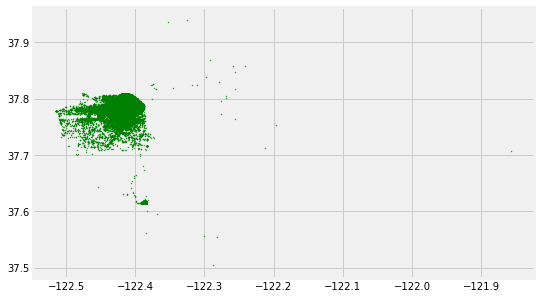

In [8]:
plt.figure(figsize=(8,5))
plt.scatter(sf_taxi_trips['start_lng'],
            sf_taxi_trips['start_lat'],
            color='green',
            alpha=.6,s=1)

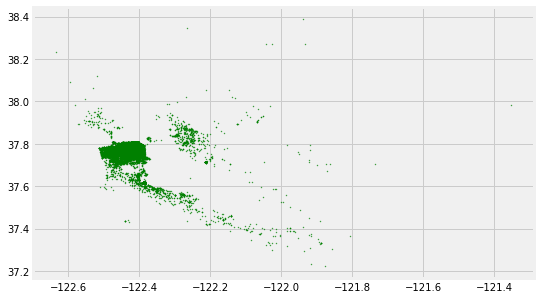

In [9]:
plt.figure(figsize=(8,5))
plt.scatter(sf_taxi_trips['end_lng'],
            sf_taxi_trips['end_lat'],
            color='green',
            alpha=.6,s=1)

We see that most trips start either in San Francisco or near SFO.

Most trips end in San Francisco, but there is a good amount distributed between San Francisco and Stanford, as well as some in Oakland and Berkeley.

A minority of the trips end far away from San Francisco.

### Classify SFO trips

Now we want to classify trips departing from SFO. And explore how they impact the cost of rides.

In [10]:
# Trips starting from the airport - TAZ 239
def trips_from_SFO(start_taz):
    return (start_taz==239)*1

sf_taxi_trips['airport'] = sf_taxi_trips.apply(lambda start_taz : 
                                               trips_from_SFO(start_taz),
                                               ['start_taz'])

/srv/app/venv/lib/python3.6/site-packages/datascience/tables.py:361: FutureWarning: column lists are deprecated; pass each as an argument
  "column lists are deprecated; pass each as an argument", FutureWarning)


Text(0.5, 1.0, 'Fare Amount Distribution')

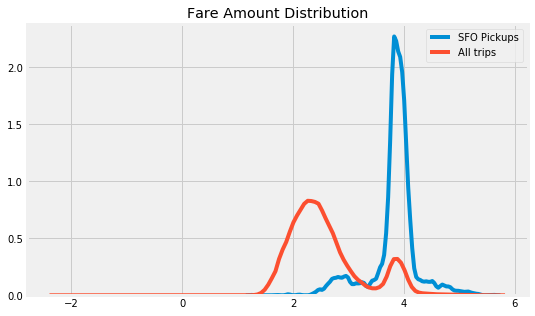

In [11]:
SFO_data = sf_taxi_trips.where('airport',1)

plt.figure(figsize=(8,5))
sns.kdeplot(np.log(SFO_data['fare']),label='SFO Pickups')
sns.kdeplot(np.log(sf_taxi_trips['fare']),label='All trips')
plt.title("Fare Amount Distribution")

We see that SFO-pickups are skewed towards higher prices. 

This may have many reasons, one is that people generally tend to travel longer when they travel from the airport and home, than e.g. from downtown San Francisco and home to another part of San Francisco.

In [12]:
def trips_to_SFO(end_taz):
    return(end_taz==239)*1

sf_taxi_trips['SFO_dropoff'] = sf_taxi_trips.apply(lambda end_taz : 
                                               trips_to_SFO(end_taz),
                                               ['end_taz'])

Text(0.5, 1.0, 'Dropoffs vs Fare Amount')

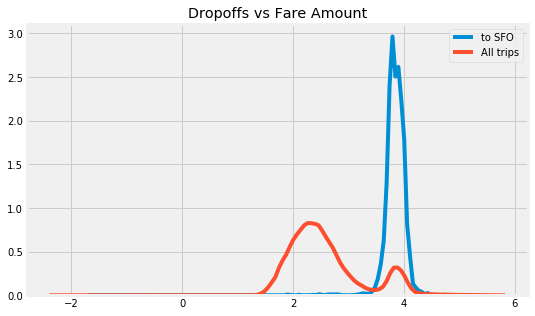

In [13]:
SFO_dropoff = sf_taxi_trips.where('SFO_dropoff',1)

plt.figure(figsize=(8,5))
sns.kdeplot(np.log(SFO_dropoff['fare']),label='to SFO')
sns.kdeplot(np.log(sf_taxi_trips['fare']),label='All trips')
plt.title("Dropoffs vs Fare Amount")

SFO-dropoffs are also skewed towards higher prices, presumably for the same reasons as for trips from SFO.

In [14]:
del SFO_data
del SFO_dropoff

### Calculate distances 

In [15]:
# We get the code for finding nearest coordinates from minilab 2:
def distance_on_sphere(lat1, lon1, lat2, lon2):
    """ Computes distance (in miles) on the surface of the Earth
        between two locations
        
        Args:
            lat1 (float): latitude of the first location
            lon1 (float): longitude of the first location
            lat2 (float): latitude of the second location
            lon2 (float): longitude of the second location
        
        Returns:
            Distance in miles (float)
    """
    # Convert latitude and longitude to spherical coordinates in radians.
    degrees_to_radians = np.pi/180.0
        
    # phi = 90 - latitude
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians
        
    # theta = longitude
    theta1 = lon1*degrees_to_radians
    theta2 = lon2*degrees_to_radians
        
    # We can compute spherical distance from spherical coordinates.
    cos = (np.sin(phi1)*np.sin(phi2)*np.cos(theta1-theta2)+
           np.cos(phi1)*np.cos(phi2))
    arc = np.arccos(cos)

    # Multiply arc by the radius of the earth to get length.
    return 3960.*arc  # to get distance in miles

In [16]:
sf_taxi_trips['distance'] = sf_taxi_trips.apply(
    lambda lat1, lon1, lat2, lon2 : 
    distance_on_sphere(lat1, lon1, lat2, lon2), 
    ['start_lat', 'start_lng', 'end_lat','end_lng'])

### Graphs of distance data

Text(0.5, 1.0, 'Distribution of Trip Distance (log scale)')

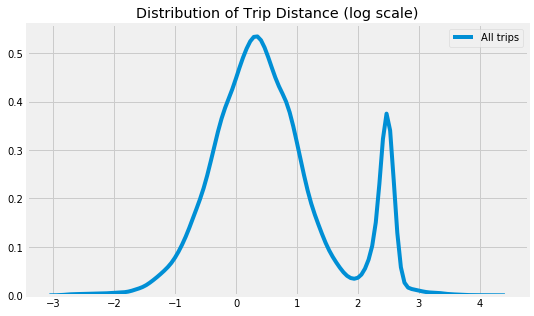

In [17]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(
    sf_taxi_trips['distance']),label='All trips')
plt.title("Distribution of Trip Distance (log scale)")

Text(0.5, 1.0, 'Distance vs Amount')

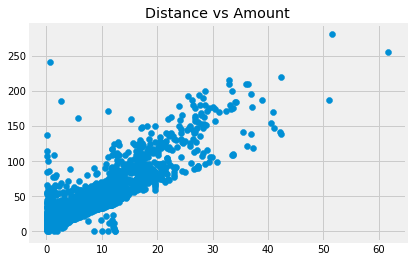

In [18]:
x=sf_taxi_trips['distance']
y=sf_taxi_trips['fare']
plt.scatter(x,y)
plt.xlabel='Distance'
plt.ylabel='Fare'
plt.title('Distance vs Amount')

Both Distribution of trip distance and the scatter plot indicate high variability of trip distances.

There is also a spike of higher distance-trip which might be SFO-trips.

Let's see if our inclination is true:

Text(0.5, 1.0, 'Distribution of Trip Distance (log scale)')

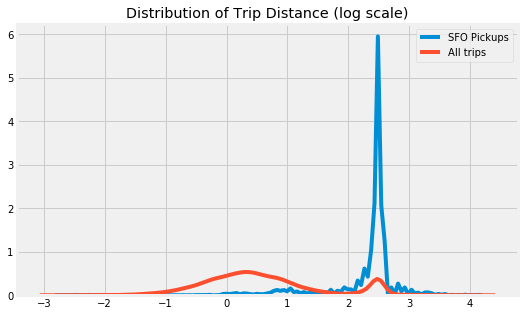

In [19]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(
    sf_taxi_trips.where('airport',1)['distance']),
            label='SFO Pickups')

sns.kdeplot(np.log(
    sf_taxi_trips['distance']),
            label='All trips')
plt.title("Distribution of Trip Distance (log scale)")

What about SFO dropoffs?

Text(0.5, 1.0, 'Distribution of Trip Distance (log scale)')

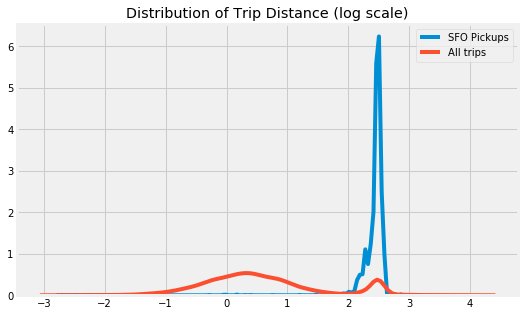

In [20]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(
    sf_taxi_trips.where('SFO_dropoff',1)['distance']),
            label='SFO Pickups')

sns.kdeplot(np.log(
    sf_taxi_trips['distance']),
            label='All trips')
plt.title("Distribution of Trip Distance (log scale)")

It does indeed seem like SFO pickups and dropoffs makes up the majority of trips from that region.

### Classify pick-up and length of trips. 

In [21]:
sf_mean_lat = 37.766016
sf_mean_lng = -122.332099

def within_15_mi_SF(start_lat,start_lng):
    # Pickup is calculated from center of SF, with radius 3.9mi + 15mi.
    return (distance_on_sphere(start_lat, start_lng, sf_mean_lat, sf_mean_lng) < 18.9)*1

# Trips more than 15 miles:
def long_trips(start_taz,start_lat,start_lng,end_lat,end_lng,airport):
    
    if(airport): # Trips starting from the airport
        if(end_lat<start_lat or (end_lat<start_lat and end_lng>start_lng)): # is the trip from SFO in SE direction?
            #Returns True/1 if trip goes South-East >15mi from airport.
            return (distance_on_sphere(start_lat, start_lng, end_lat, end_lng)>15)*1
    # Trips from SF or from SFO through SF
    # Returns True/1 if trip goes >15mi from city borders.
    return  (distance_on_sphere(sf_mean_lat, sf_mean_lng, end_lat, end_lng)>18.9)*1

In [22]:
sf_taxi_trips['start_in_SF'] = sf_taxi_trips.apply(lambda start_lat, start_lng
                                                     : within_15_mi_SF(start_lat,start_lng), ['start_lat','start_lng'])

sf_taxi_trips['long_trips'] = sf_taxi_trips.apply(lambda start_taz, start_lat, start_lng, end_lat, end_lng, airport :
                                                  long_trips(start_taz,start_lat,start_lng,end_lat,end_lng,airport), 
                                                  ['start_taz','start_lat','start_lng','end_lat','end_lng','airport'])

### Remove outliers 

The following methods are very experimental, and take basis on the removal of outliers in all directions: fare, distance or duration.

However, by assumption that long trips cost more than shorter trips, we first split our training data according to the above method so that we can effectively predict fares for both short and long trips.

So, what is, graphically, the effect of removing outliers?

Let's find out:

In [23]:
from scipy import stats

def table_of_outliers(table,feature1='distance',feature2='fare',feature3='duration'):
    
    return_table=table
    
    values = return_table.select([feature1,feature2,feature3]).values
    
    # Calculate z-values.
    z=np.abs(stats.zscore(values))
    
    z=z.transpose() # Transpose the table to separate distance and fare z-values
    
    return_table = return_table.with_column('z_'+feature1, z[0]).with_column('z_'+feature2, z[1]).with_column('z_'+feature3,z[2])
    
    
    # This code selects if ALL of duration, fare and distanace are outliers.
    
    #rt1 = return_table.where(return_table['z_'+feature1]>3)
    #rt2 = rt1.where(rt1['z_'+feature2]>3)
    #rt3 = rt2.where(rt2['z_'+feature3]>3)
    
    
    # This code selects if ANY of duration, fare and distance are outliers.
    
    rt1 = return_table.where(return_table['z_'+feature1]>3)
    rt2 = return_table.where(return_table['z_'+feature2]>3)
    rt3 = return_table.where(return_table['z_'+feature3]>3)
    rt3.append(rt2.append(rt1))
    
    return rt3

In [24]:
short_trips_outliers = table_of_outliers(sf_taxi_trips.where('long_trips',0))
long_trips_outliers = table_of_outliers(sf_taxi_trips.where('long_trips',1))

Text(0.5, 1.0, 'Distance vs Amount (long trips)')

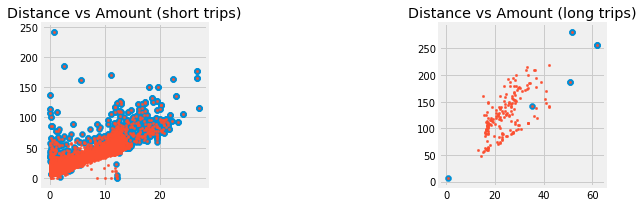

In [25]:
#ANY of dist, fare, dur, are outliers

plt.figure(1, figsize=(9,3))

plt.subplot(131)
x=short_trips_outliers['distance']
y=short_trips_outliers['fare']
plt.scatter(x,y, label='short outliers')

x3=sf_taxi_trips.where('long_trips',0)['distance']
y3=sf_taxi_trips.where('long_trips',0)['fare']
plt.scatter(x3,y3,s=5, label='Short trips')

plt.title('Distance vs Amount (short trips)')

plt.subplot(133)

x2=long_trips_outliers['distance']
y2=long_trips_outliers['fare']
plt.scatter(x2,y2, label='long outliers')

x4=sf_taxi_trips.where('long_trips',1)['distance']
y4=sf_taxi_trips.where('long_trips',1)['fare']
plt.scatter(x4,y4,s=5, label='Long trips')

plt.title('Distance vs Amount (long trips)')

We see that for both short and long trips, we remove most of what may be considered "outlier".

Note that we may well have removed way too many data points. The method here, in nature does not take in to account effects like rush-hour, which is something that surely happens and impacts the fare.

The effect of rush hour will be explored later on.

### Label the outliers in a separate column. 

In [26]:
def z_values(table,ft1,ft2,ft3):
    return_table=table
    
    values = return_table.select([ft1,ft2,ft3]).values
    z=np.abs(stats.zscore(values)).transpose()
    
    return_table = return_table.with_column(
        'z_'+ft1, z[0]).with_column(
        'z_'+ft2, z[1]).with_column(
        'z_'+ft3, z[2])
    
    return return_table

def label_outliers(z_dist,z_fare,z_dur):
    # Returns True if distance, fare or duration are outliers.
    return (z_dist>3 or z_fare>3 or z_dur>3)*1

# Split then compute outliers
sf_short = sf_taxi_trips.where('long_trips',0)
sf_short = z_values(sf_short,'duration','fare','distance')
sf_short['outlier'] = sf_short.apply(lambda z_dist,z_fare,z_dur : 
                                     label_outliers(z_dist,z_fare,z_dur), 
                                     ['z_distance','z_fare','z_duration'])

sf_long = sf_taxi_trips.where('long_trips',1)
sf_long = z_values(sf_long,'duration','fare','distance')
sf_long['outlier'] = sf_long.apply(lambda z_dist,z_fare,z_dur : 
                                   label_outliers(z_dist,z_fare,z_dur), 
                                   ['z_distance','z_fare','z_duration'])


sf_2 = sf_short.append(sf_long)


In [90]:
# This table sf_taxi_trips with all outliers removed.
sf_2_train, sf_2_test = sf_2.split(int(sf_2.num_rows*0.66))
sf_2_split_cleaned = sf_2_train.where('outlier',0)

In [28]:
sf_2_split_cleaned_df = Table.to_df(sf_2_split_cleaned)
sf_2_split_cleaned_df.corr()['fare'].sort_values()

end_lat       -0.584731
start_lat     -0.559994
day of week   -0.092852
start hour    -0.019737
number_pax    -0.002231
id             0.024703
start_lng      0.177959
z_duration     0.397789
end_lng        0.428701
long_trips     0.460974
start_taz      0.463520
end_taz        0.475942
SFO_dropoff    0.505071
airport        0.572229
z_fare         0.700822
z_distance     0.711772
duration       0.810363
distance       0.962726
fare           1.000000
start_in_SF         NaN
outlier             NaN
Name: fare, dtype: float64

It seems here that distance (which will be the main metric of our model), is extremely well correlated with the fare. And at first one might fall into the trap of concluding that using a linear model would give very good results.

And we will get very good results - but only for test-sets that does not contain any "outliers" (outliers in terms of the z-value of our metrics defined as above).

And even if we were able to predict the fare of non-"outlier" trips, we have no way of actually computing fare or duration in our test-sets (without using a model, that is!), so inherently we cannot know whether a given trip will be an outlier or not.

I have chosene to include this for it's interesting learning opportunity and perhaps usefulness in a more thoroughly worked-with model.

### Graph the cleaned tables: 

Text(0.5, 1.0, 'distance vs Amount')

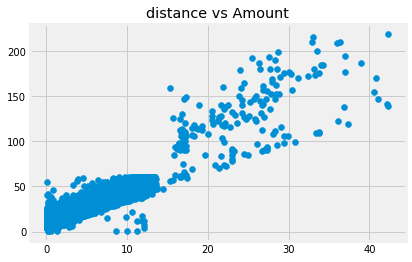

In [29]:
x=sf_2_split_cleaned['distance']
y=sf_2_split_cleaned['fare']
plt.scatter(x,y)
plt.xlabel='distance'
plt.ylabel='Fare'
plt.title('distance vs Amount')

### Graphs of different types of trips 

In [30]:
# Source for the below function:
# https://medium.com/analytics-vidhya/machine-learning-to-predict-taxi-fare-part-one-exploratory-analysis-6b7e6b1fbc78?fbclid=IwAR2V4GN9g3YG2ufiVj5Tgy9Bk3HNsdf9yz8UyzcRr_LxJoqFdUjYvT5NjWo

def groupandplot(data,groupby_key,value,aggregate='mean'):
    plt.figure(figsize=(16,10))
    agg_data=data.groupby([groupby_key])[value].agg(aggregate).reset_index().rename(columns={value:aggregate+'_'+value})
    plt.subplot(1,2,1)
    count_data=Table.to_df(sf_taxi_trips).groupby([groupby_key])['id'].count().reset_index().rename(columns={'id':'Num_Trips'})
    sns.barplot(x=groupby_key,y='Num_Trips',data=count_data).set_title("Number of Trips vs "+groupby_key)
    
    plt.subplot(1,2,2)
    sns.barplot(x=groupby_key,y=aggregate+'_'+value,data=agg_data).set_title(aggregate+'_'+value+" vs "+groupby_key)

/srv/app/venv/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


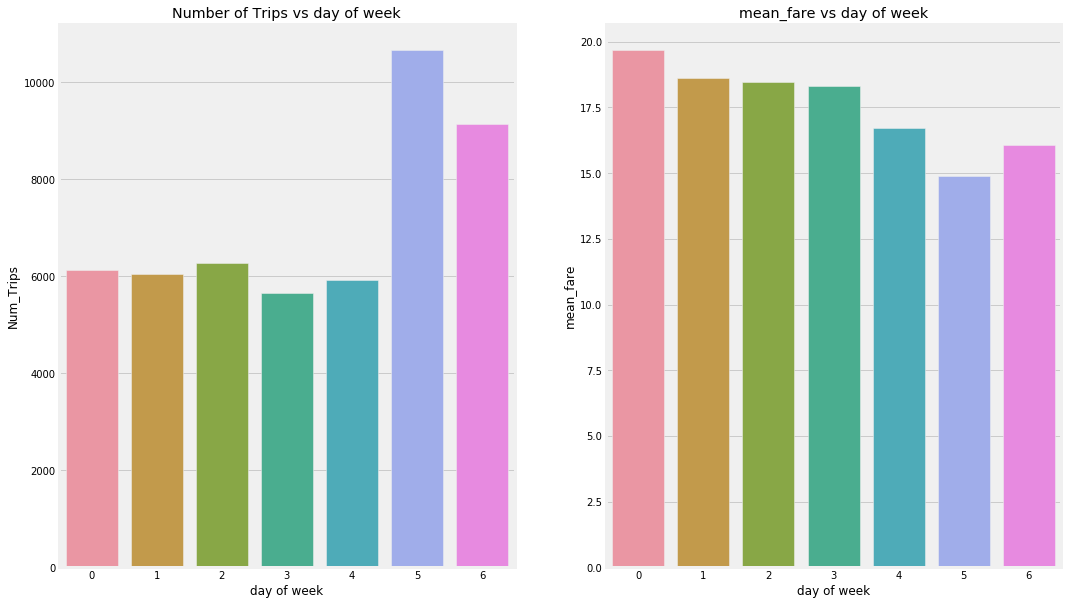

In [31]:
groupandplot(Table.to_df(sf_taxi_trips),'day of week','fare')

There is a big difference between the number of trips on weekdays and weekends, but we cannot be certain if the difference in fare, which isn't significantly lower during weekends is due to the day of the week.

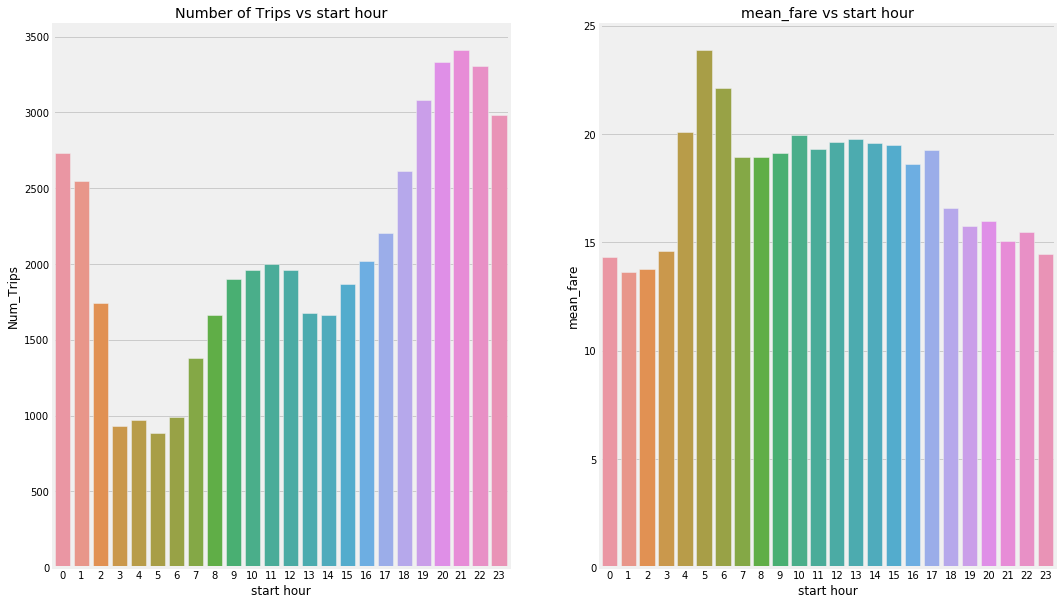

In [32]:
groupandplot(Table.to_df(sf_taxi_trips),'start hour','fare')

We see big differences in the number of trips throughout the day on any given day. 

There are also some differences between the fares on different hours of the day.
There can be many reasons for this. Maybe there's less taxis available? Higher prices at night? People take longer trips at that time of day?

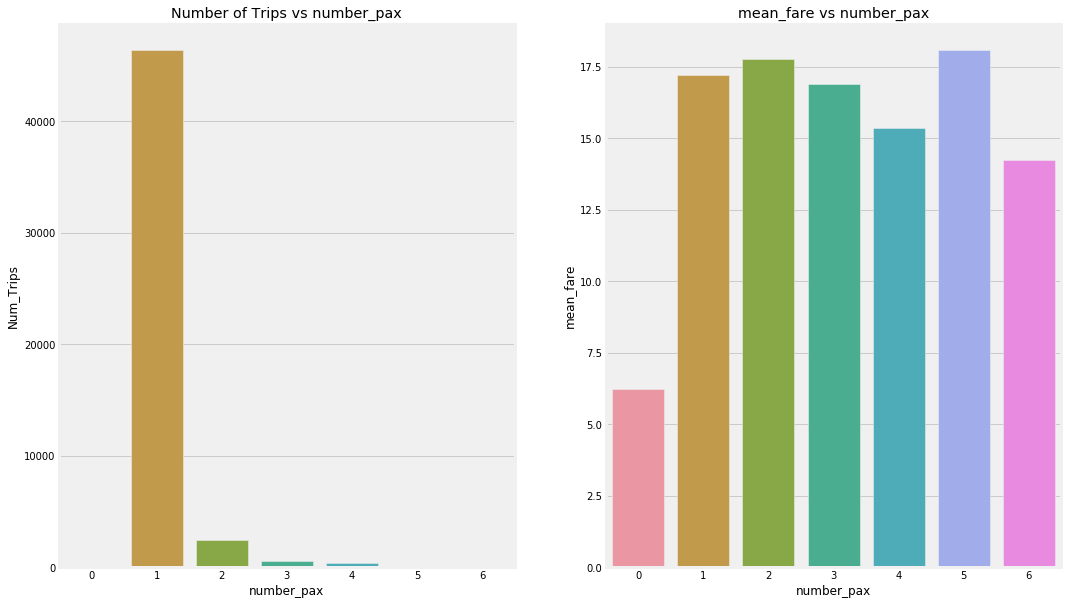

In [33]:
groupandplot(Table.to_df(sf_taxi_trips),'number_pax','fare')

We see that we have some trips with 0 passengers, that doesn't make sense to us - so we remove the fare.

Other things to note: The number of passengers are not more than 6. (This is also true for the test-set, although not plotted here).

In [34]:
sf_taxi_trips = sf_taxi_trips.where(sf_taxi_trips['number_pax']>0)

#### Peak hours

Based on the information above, we create a metric to differ between peak and non-peak hours.



In [35]:
def peak_hours(hour):
    return (4 <= hour <= 17)*1

sf_taxi_trips['peak_hour'] = sf_taxi_trips.apply(lambda hour: peak_hours(hour), ['start hour'])

Text(0.5, 1.0, 'Distance vs Amount (peak v. non-peak)')

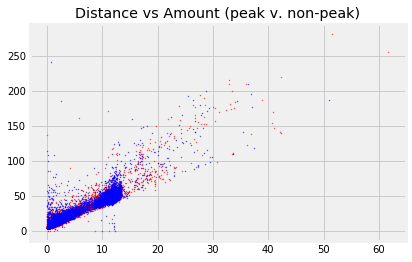

In [36]:
# Peak hours
plt.figure()
x=sf_taxi_trips.where('peak_hour',0)['distance']
y=sf_taxi_trips.where('peak_hour',0)['fare']
plt.scatter(x,y, color='red',label='non-peak', alpha=0.5, s=1)

x=sf_taxi_trips.where('peak_hour',1)['distance']
y=sf_taxi_trips.where('peak_hour',1)['fare']
plt.scatter(x,y, color='blue',label='non-peak', alpha=0.5, s=1)

plt.title('Distance vs Amount (peak v. non-peak)')

There are no obvious way to look at peak-vs, non-peak trips.

# Building a model to predict taxi-fares

### Import the test-table 

In [87]:
test= Table.read_table('Taxi_Query.csv')
test['distance'] = test.apply(
    lambda lat1, lon1, lat2, lon2 : 
    distance_on_sphere(lat1, lon1, lat2, lon2), 
    ['start_lat', 'start_lng', 'end_lat','end_lng'])

test['airport'] = test.apply(lambda start_taz : 
                                               trips_from_SFO(start_taz),
                                               ['start_taz'])

test['long_trips'] = test.apply(lambda start_taz, start_lat, start_lng, end_lat, end_lng, airport :
                                                  long_trips(start_taz,start_lat,start_lng,end_lat,end_lng,airport), 
                                                  ['start_taz','start_lat','start_lng','end_lat','end_lng','airport'])

## Simulate training and testing data

In [37]:
sf_train, sf_test = sf_taxi_trips.split(int(sf_taxi_trips.num_rows*2/3))

#sf_train = sf_taxi_trips

# Let's build the prediction model using linear regression.

In [38]:
def linear_mse(any_slope,any_intercept):
    """ Returns the line of best fit for the given 
        x_col and y_col given before the call of the function.
    """
    fitted = any_slope*x_col + any_intercept
    return np.mean((y_col - fitted) ** 2)



In [39]:
def rmse(predictions, targets):
    """ Computes root mean squared error for a given prediction
        and known result."""
    return np.sqrt(((predictions - targets) ** 2).mean())

### How to structure a model
There are many ways to build a linear model to predict taxi fares.

The easiest way would be to disregard everything we found in the EPA-phase, and instead only use distance as input and fare as output, and build a model based on our training data.

However, we can do better.
The first, and obvious way is to take into consideration the length of the trip. Now, this was not explored in detail in EPA, but it is a reasonable assumption given that YellowCabSF states on their website that trips 15 miles outside SF or 15 miles from SFO (with some subset of complications) result in a 150% of fare.

The long_trip-method above estimates that boundary and is the main addition to give improvement of a simple model. To future improvements, a more sophisticated construction and evaluation of such split would probably improve results.

### One-layer models

First, we consider models with only one feature-split.
e.g. split only on short vs. long trips.

In [41]:
def generalized_split_model(table,label,x_label,y_label):
    """ This method computes one-layer models.
    Inputs: table, the table with the necessary data to compute a model
            label, a single label for which we wish to split the data into in order to
                    make a split.
            x_label, the name of the column containing the independent variable
            y_label, the name of the column containing the value we are making a model to predict.
    Outputs: A 2x2 matrix containing the slope and intercept of two linear models.
                The first row contains the model of label=True
                The second row contains the model of label=False
                The first column contains the slope of the model
                The second column contains the intercept of the model
    """
    
    def sub_linear_mse(any_slope,any_intercept):
        """ This method is local to generalized_split_model.
        Creates a linear model with given x_col and y_col,
        where x_col and y_col are defined immediately before this function is called.
        Inputs: any_slope and any_intercept, these variables are 
                computed by the minimize-method.
        Returns: The equation for the line of best fit for the given x_col, y_col."""
        fitted = any_slope*x_col + any_intercept
        return np.mean((y_col - fitted) ** 2)
    
    # CASE: 'label' = True
    data1 = table.where(label,1)
    x_col = data1.column(x_label)
    y_col = data1.column(y_label)

    model_1 = minimize(sub_linear_mse)

    # CASE: 'label' = False
    data0 = table.where(label,0)
    x_col = data0.column(x_label)
    y_col = data0.column(y_label)

    model_0 = minimize(sub_linear_mse)
    return_model = make_array(model_1,model_0)

    return return_model

In [71]:
def simulate_model_performance(table, feature, sample_size, repetitions, x_label, y_label):
    """ This method computes generalized_split_model iteratively, giving
        an average model over the given number of repetitions.
    Inputs: table, the table containing the necessary data points
            label, to split cases on
            sample_size, Desired sample size from table
            Number of repetitions of simulation
            x_label, y_label, the independent and dependent variable names 
                (should correspond to column names in table)
    """
    def sub_predict(x_val, feature):
        """ This method is local to the simulate_model_performance method.
        Inputs: x_val, the independent variable of the prediction.
                label, the feature for which we decide which of the 
                one-layer models to use."""
        if(feature):
            return x_val*models[0][0]+models[0][1]
        else:
            return x_val*models[1][0]+models[1][1]
    
    
    bootstrap_rmse = make_array()
    model_array = []
    bs2 = make_array()
    for i in range(repetitions):        
        new_train, new_test = table.split(sample_size)
        models = generalized_split_model(new_train,feature,x_label,y_label)
        new_test['pred_'+y_label] = new_test.apply(lambda dist,ft:
                                               sub_predict(dist,ft),
                                              [x_label,feature])
        res = rmse(new_test.column('pred_'+y_label), new_test.column(y_label))
        bootstrap_rmse = np.append(bootstrap_rmse,res)
        model_array.append(models)

        
    #temp = model_array[0][1]
    #fin = [model_array[1:],temp]
    
    mean_rmse = np.mean(bootstrap_rmse)
    std_rmse = np.std(bootstrap_rmse)
    
    
    def avg_model(array):
        """ This method is local to the simulate_model_performance method.
        It averages the inputted array - we expect a 2x2 matrix, where each
        cell is averaged individually.
        Inputs: array, the array to be averaged.
        Output: the array, averaged."""
        summed = array[0] - array[0]
        for i in range(0,len(array)-1):
            summed = summed + array[i]

        avg_array = summed/len(array)

        return avg_array

    return_model = avg_model(model_array)
    print('mean rmse: '+str(mean_rmse)+'. Std: '+str(std_rmse))
    
    return return_model
    

In [53]:
def general_predict(x_var,truth_value):
    """ This method gives a returns an array of output values,
    predicted by a provided array of input-values, computed through the
    given model. Note avg_predictor has to be called immediately before the
    method is run.
    Inputs: x_val, the independent variable of the prediction.
            label, the feature for which we decide which of the 
            one-layer models to use.
    Output: an array with the predicted values."""
    if(truth_value):
        return x_var*avg_predictor[0][0]+avg_predictor[0][1]
    else:
        return x_var*avg_predictor[1][0]+avg_predictor[1][1]


## Experimenting with different features to produce different models

In [77]:
n=int(sf_taxi_trips.num_rows*0.8)
reps=5

### No split: 

In [78]:
avg_predictor_nosplit=simulate_model_performance(sf_taxi_trips, 'long_trips', n, reps,'distance','fare')

mean rmse: 4.980560301853169. Std: 0.3766325951437542


### Split on Peak hours

In [79]:
avg_predictor_peak=simulate_model_performance(sf_taxi_trips, 'peak_hour', n, reps,'distance','fare')

mean rmse: 5.254040748693869. Std: 0.26655025341856775


### Split on SFO vs. SF (pickups)

In [80]:
avg_predictor_peak=simulate_model_performance(sf_taxi_trips, 'airport', n, reps,'distance','fare')

mean rmse: 5.070355859666758. Std: 0.2528155776750536


### Split on SFO dropoffs vs. non (SFO dropoffs)

In [81]:
avg_predictor_peak=simulate_model_performance(sf_taxi_trips, 'SFO_dropoff', n, reps,'distance','fare')

mean rmse: 5.159021721646648. Std: 0.20876935601850213


### Split on long vs. short trips (out-of-town trips) 

In [82]:
avg_predictor_peak=simulate_model_performance(sf_taxi_trips, 'long_trips', n, reps,'distance','fare')

mean rmse: 4.830388543221264. Std: 0.32376424481960386


### Split on long vs short AND SFO vs SF 
The simulate_model_performance method is best suited for one-layer predictions, so we implement this manually.

In [94]:
long_SFO_data = sf_train.where('long_trips',1).where('airport',1)
x_col = long_SFO_data.column('distance')
y_col = long_SFO_data.column('fare')

long_SFO_model = minimize(linear_mse)

short_SFO_data = sf_train.where('long_trips',0).where('airport',1)
x_col = short_SFO_data.column('distance')
y_col = short_SFO_data.column('fare')

short_SFO_model = minimize(linear_mse)

long_SF_data = sf_train.where('long_trips',1).where('airport',0)
x_col = long_SF_data.column('distance')
y_col = long_SF_data.column('fare')

long_SF_model = minimize(linear_mse)

short_SF_data = sf_train.where('long_trips',0).where('airport',0)
x_col = short_SF_data.column('distance')
y_col = short_SF_data.column('fare')

short_SF_model = minimize(linear_mse)

In [95]:
def predict(dist,long,sfo):

    if(long and sfo):
        return dist*long_SFO_model[0]+long_SFO_model[1]
    elif(long and (not sfo)):
        return dist*long_SF_model[0]+long_SF_model[1]
    elif((not long) and sfo):
        return dist*short_SFO_model[0]+short_SFO_model[1]
    elif(not(long and sfo)):
        return dist*short_SF_model[0]+short_SF_model[1]
    else:
        raise NameError("you shouldn't be here")

In [96]:
sf_test['predicted_fare'] = sf_test.apply(lambda dist, long, sfo : 
                                          predict(dist,long, sfo), 
                                          ['distance','long_trips','airport'])

In [97]:
rmse_sfo_ls = rmse(sf_test.column('fare'),
                   sf_test.column('predicted_fare'))
print('rmse = '+str(rmse_sfo_ls))

rmse = 4.596963543727496


In [98]:
test['predicted_fare'] = test.apply(lambda dist, long, sfo : 
                                          predict(dist,long, sfo), 
                                          ['distance','long_trips','airport'])
test.select(['id','fare']).to_df().to_csv('submission.csv', index = False)

The above csv ended up being my final submission on Kaggle.

### Lastly, we manually implement a model to check out what happens with our "cleaned" data 

In [91]:
long_SFO_data = sf_2_split_cleaned.where('long_trips',1).where('airport',1)
x_col = long_SFO_data.column('distance')
y_col = long_SFO_data.column('fare')

long_SFO_model = minimize(linear_mse)

short_SFO_data = sf_2_split_cleaned.where('long_trips',0).where('airport',1)
x_col = short_SFO_data.column('distance')
y_col = short_SFO_data.column('fare')

short_SFO_model = minimize(linear_mse)

long_SF_data = sf_2_split_cleaned.where('long_trips',1).where('airport',0)
x_col = long_SF_data.column('distance')
y_col = long_SF_data.column('fare')

long_SF_model = minimize(linear_mse)

short_SF_data = sf_2_split_cleaned.where('long_trips',0).where('airport',0)
x_col = short_SF_data.column('distance')
y_col = short_SF_data.column('fare')

short_SF_model = minimize(linear_mse)

In [92]:
sf_2_test['predicted_fare'] = sf_2_test.apply(lambda dist, long, sfo : 
                                          predict(dist,long, sfo), 
                                          ['distance','long_trips','airport'])

In [93]:
rmse_cleaned = rmse(sf_2_test.column('fare'),
                   sf_2_test.column('predicted_fare'))
print('rmse = '+str(rmse_cleaned))

rmse = 4.961099267907749


#### Last notes:
The models are pretty similar, and can definitely be improved. I left some methods here that can be combined in different ways to facilitate for that.

So there is no way of saying definitely which method is always the best, as they produce slighly different values on each run since I split the training set.